<html>
<font color = green size = 6>
<b>
Time Series Forecasting of hourly data using Tensorflow
</b>
</font>
</html>

In [1]:
import pandas as pd
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("timeseries_wow_hourly_train.csv", index_col = "DateTime")

In [3]:
data.head(5)

,PlayersCount
DateTime,
1/1/2006 0:00,4878
1/1/2006 1:00,4854
1/1/2006 2:00,4558
1/1/2006 3:00,3794
1/1/2006 4:00,2870


In [4]:
series = data['PlayersCount'] 
series.head(10)

DateTime
1/1/2006 0:00    4878
1/1/2006 1:00    4854
1/1/2006 2:00    4558
1/1/2006 3:00    3794
1/1/2006 4:00    2870
1/1/2006 5:00    2004
1/1/2006 6:00    1376
1/1/2006 7:00    1134
1/1/2006 8:00    1304
1/1/2006 9:00    1956
Name: PlayersCount, dtype: int64

In [6]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


In [7]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [8]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [9]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [10]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [11]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [12]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [13]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [14]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [15]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [16]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [17]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [18]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 10, 4)

In [19]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.06892812],
       [ 0.08625554],
       [ 0.08475064],
       ..., 
       [-0.65559006],
       [-0.65664989],
       [-0.66087061]], dtype=float32)

In [21]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Time=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Time=1, Predicted=-1544.160160, Expected=1450.000000
Time=2, Predicted=-1680.239737, Expected=1737.000000
Time=3, Predicted=-1339.753761, Expected=1844.000000
Time=4, Predicted=-1252.624352, Expected=1767.000000
Time=5, Predicted=-1357.669659, Expected=2039.000000
Time=6, Predicted=-1037.223542, Expected=1944.000000
Time=7, Predicted=-1179.360018, Expected=1570.000000
Time=8, Predicted=-1596.600141, Expected=1894.000000
Time=9, Predicted=-1172.181445, Expected=2277.000000
Time=10, Predicted=-773.033244, Expected=2329.000000
Time=11, Predicted=-773.771358, Expected=2660.000000
Time=12, Predicted=-411.195297, Expected=2132.000000


In [22]:
#report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3160.213


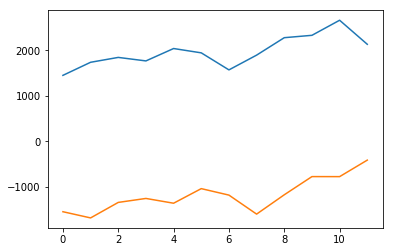

In [23]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

<html>
<font color = blue size = 4>
<b>
Model accuracy is less compared to HoltWInters method.
</b>
</font>
</html>